<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.8.0/cudaq_qaoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up CUDA-Q Environment**

In [ ]:
%pip install cuda-quantum==0.8.0

# Quantum Approximate Optimization Algorithm

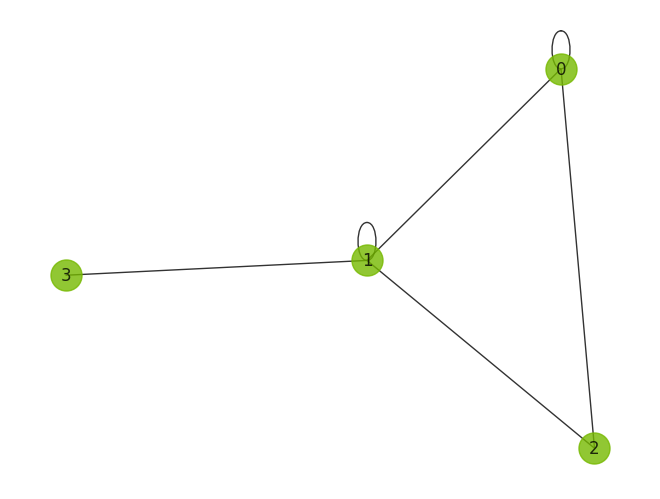

In [ ]:
import networkx as nx
import numpy as np

coefficient_matrix = np.array([[ -1.,  3.1,  1.5,  0. ],
                               [ 3.1, -1.5,  2.3,  1.9],
                               [ 1.5,  2.3,  0.,   0. ],
                               [ 0.,   1.9,  0.,   0. ]])


#Create a weighted NetworkX graph from coefficient matrix to visualize the problem
G = nx.from_numpy_array(coefficient_matrix)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='#76B900')

In [ ]:
# Construct the lists of 1st-order and 2nd-order terms from problem matrix
first_order = []
second_order = []
for i in range(coefficient_matrix.shape[0]):
    # 1st-order terms: Node weights from diagonal
    if coefficient_matrix[i, i] != 0:
        first_order.append((i, coefficient_matrix[i, i]))

    # 2nd-order terms: Edge weights from off-diagonal elements
    for j in range(i + 1, coefficient_matrix.shape[1]):  # Upper triangle for undirected edges
        if coefficient_matrix[i, j] != 0:
            second_order.append((i, j, coefficient_matrix[i, j]))


# Preprint the terms of the problem
print("First-order terms (node weights):", first_order)
print("Second-order terms (edge weights):", second_order)

First-order terms (node weights): [(0, -1.0), (1, -1.5)]
Second-order terms (edge weights): [(0, 1, 3.1), (0, 2, 1.5), (1, 2, 2.3), (1, 3, 1.9)]


In [ ]:
import cudaq
from cudaq import spin
from typing import List
import numpy as np


# The problem Hamiltonian
hamiltonian = 0
for (i, w) in first_order:
    hamiltonian += w * spin.z(i)
for (i, j, w) in second_order:
    hamiltonian += w * spin.z(i) * spin.z(j)


# Parameters of QAOA
qubit_count = int(coefficient_matrix.shape[0])
layer_count: int = 2
parameter_count: int = 2 * layer_count


# Flatten the lists that serve as CUDA-Q arguments
first_order = [float(item) for sublist in first_order for item in sublist]
second_order = [float(item) for sublist in second_order for item in sublist]


@cudaq.kernel
def kernel_qaoa(qubit_count: int, first_order: List[float], second_order: List[float], layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Problem unitary: 1st-order terms
        for i in range(int(len(first_order)/2)):
            q = int(first_order[2*i])
            rz(2.0*first_order[2*i+1]*thetas[layer], qvector[q])

        # Problem unitary: 2nd-order terms
        for i in range(int(len(second_order)/3)):
            q1, q2 = int(second_order[3*i]), int(second_order[3*i+1])
            x.ctrl(qvector[q1], qvector[q2])
            rz(2.0 * second_order[3*i+2]*thetas[layer], qvector[q2])
            x.ctrl(qvector[q1], qvector[q2])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)
print(cudaq.draw(kernel_qaoa, qubit_count, first_order, second_order, layer_count, optimizer.initial_parameters))

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]
     ╭───╮╭─────────────╮                                               »
q0 : ┤ h ├┤ rz(-0.4362) ├──●─────────────────●────●──────────────────●──»
     ├───┤├─────────────┤╭─┴─╮╭───────────╮╭─┴─╮  │                  │  »
q1 : ┤ h ├┤ rz(-0.6543) ├┤ x ├┤ rz(1.352) ├┤ x ├──┼──────────────────┼──»
     ├───┤╰─────────────╯╰───╯╰───────────╯╰───╯╭─┴─╮╭────────────╮╭─┴─╮»
q2 : ┤ h ├──────────────────────────────────────┤ x ├┤ rz(0.6543) ├┤ x ├»
     ├───┤                                      ╰───╯╰────────────╯╰───╯»
q3 : ┤ h ├──────────────────────────────────────────────────────────────»
     ╰───╯                                                              »

################################################################################

╭────────────╮╭────────────╮                                           »
┤ rx(0.5094) ├┤ rz(0.4123) ├───────────────────────────────────────────»

In [ ]:
import time


# Define the simulation target:
cudaq.set_target("nvidia")  # "nvidia" for GPU, "qpp-cpu" for CPU


# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, first_order, second_order, layer_count,
                         parameters).expectation()


# Optimize!
t0 = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)
print("Execution time =", round(time.time()-t0, 3), "(s)")

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count,  first_order, second_order, layer_count, optimal_parameters, shots_count=2**18)
print(counts)

max = 0
for bitstring in counts:
    if counts[bitstring] > max:
        max = counts[bitstring]
        bitstring_max = bitstring
print("The optimal bitstring with max. number of shots =", bitstring_max)

Execution time = 0.147 (s)
Optimal value =  -2.9962138512302774
Optimal parameters =  [-1.4334297988025442, -0.5508928196383609, -0.8020490314806129, 0.6953739970831859]
{ 0111:23943 1011:327 0000:78 0011:7277 1000:2884 1101:7076 0100:81609 1100:17827 0110:83307 0010:26498 1010:81 1001:428 1110:2342 0001:533 1111:25 0101:7909 }

The optimal bitstring with max. number of shots = 0110
